In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
#os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
# use GPU, cuda enabled
from numba import jit, njit, vectorize, cuda, int64, float32, int16

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [12]:
@vectorize([float32(float32)], target='parallel', fastmath=True)
def log(x):
    return np.log(x)

@vectorize([float32(float32)], target='parallel', fastmath=True)
def exp(x):
    return np.exp(x)

In [13]:
A = np.array([2, 5, 10, 3, 8]).astype(np.float32)

print(log(A))
print(exp(A))

[0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
[7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

[0.00013383 0.00013386 0.00013389 ... 0.05400392 0.05399745 0.05399097]


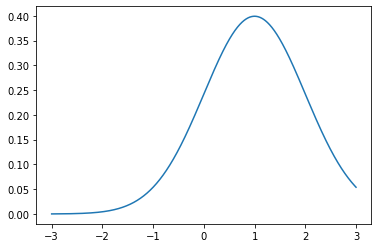

In [14]:
s = 100000
mean = 1 
std = 1

@vectorize([float32(float32)], target = 'parallel', fastmath = True)
def gaussian_pdf(x):
    return 1/(np.sqrt(2*np.pi)*std) * np.exp(-1/2*((x-mean)/std)**2)

x = np.linspace(-3, 3, s, dtype=np.float32)

g = gaussian_pdf(x)

print(g)

plt.plot(x, g)

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

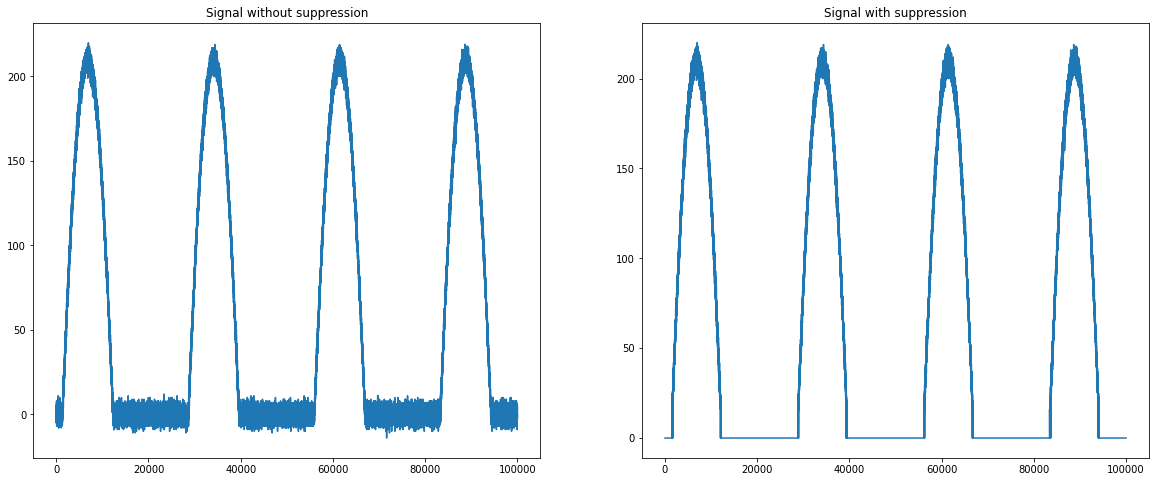

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

#put your code here
@vectorize([int16(int16)], target = 'parallel', fastmath = True)
def zero_suppression(x):
    if(x < 15):
        return 0
    return x

fig, axs = plt.subplots(1, 2, figsize = (20, 8))
axs[0].set_title("Signal without suppression")
axs[0].plot(data)
axs[1].set_title("Signal with suppression")
axs[1].plot(zero_suppression(data))

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [16]:
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

@jit(nopython = True)
def sigmoid_kernel(x, y, a, c):
    return np.tanh(a * (x.T).dot(y) + c)

print(sigmoid_kernel(X, Y, 2, 4))

[[0.99999422 0.99998067 0.99999859]
 [0.99992561 0.99995047 0.99999177]
 [0.99993351 0.99984561 0.99998569]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [17]:
# CUDA kernel
@cuda.jit
def cos_kernel_3D(io_array):
    x, y, z = cuda.grid(3)
    if x < io_array.shape[0] and y < io_array.shape[1] and z < io_array.shape[2]:
        io_array[x,y,z] = math.cos(io_array[x,y,z]) # do the computation 
                            # problems with np.cos, numba compatibility

# Host code   
data = np.random.random((256,256,256))*2*np.pi  # cos

# Configure the blocks
threadsperblock = (16, 4, 4) #ThreadsPerBlock must be a divisor of the data dimension: 1024/ 64 / 16 = 1
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

device_data = cuda.to_device(data)

cos_kernel_3D[blockspergrid, threadsperblock](device_data)

cuda.synchronize()

print(data)

[[[2.92467436 1.02003844 1.44661669 ... 1.4745572  2.79575537 1.13345651]
  [4.13234353 2.12816315 3.46937271 ... 3.52751258 4.3002074  1.09896944]
  [0.66924021 5.53342688 4.05859374 ... 2.87482966 0.26534854 0.87379028]
  ...
  [1.85650334 2.00555313 0.75803117 ... 2.81773171 1.08290915 2.57146184]
  [6.13959946 2.86524485 0.22244158 ... 5.91705909 5.06505915 6.11181542]
  [1.26924118 3.34516733 3.60330893 ... 5.93495205 2.88937809 2.29577087]]

 [[4.70477431 1.08637642 5.35497023 ... 3.88195279 1.5927423  6.24552096]
  [2.25305278 1.35017349 5.00350201 ... 1.57813076 1.82964142 2.2793706 ]
  [4.16758953 0.62693121 3.51878625 ... 6.12844457 0.49297167 6.09655687]
  ...
  [0.56260154 0.8453825  1.28823903 ... 0.12083895 4.45036643 3.25469358]
  [0.68178991 4.45922252 0.3793266  ... 0.97564889 5.59874267 3.27125409]
  [2.89746764 0.58243129 3.90763204 ... 2.22527785 5.92992572 4.34476007]]

 [[4.79449943 1.46415388 2.48249841 ... 0.58219563 4.92373675 0.4790236 ]
  [0.74237062 1.602867

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [18]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(10,size = (24,12))
B = np.random.randint(10,size = (12,22))

# Configure the blocks
threadsperblock = (16, 16)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

C = np.zeros((24,22))

device_A = cuda.to_device(A)
device_B = cuda.to_device(B)
device_C= cuda.to_device(C)

matmul[blockspergrid, threadsperblock](device_A, device_B, device_C)
cuda.synchronize()

C = device_C.copy_to_host()
print(C)

[[290. 266. 282. 206. 227. 343. 272. 215. 254. 292. 202. 227. 142. 287.
  251. 256. 109. 220. 271. 195. 296. 328.]
 [164. 163. 191. 130. 108. 215. 175. 204. 135. 153. 115. 188. 145. 171.
  109. 191. 124. 181. 192. 156. 175. 177.]
 [318. 274. 294. 278. 160. 409. 300. 285. 325. 341. 178. 311. 227. 321.
  215. 325. 251. 318. 315. 312. 355. 347.]
 [317. 288. 353. 224. 267. 453. 349. 286. 320. 327. 277. 263. 160. 292.
  303. 347. 127. 259. 291. 309. 350. 388.]
 [297. 186. 257. 232. 163. 328. 230. 173. 287. 277. 187. 221. 132. 261.
  228. 249. 103. 231. 230. 192. 263. 299.]
 [315. 286. 326. 251. 229. 391. 299. 327. 306. 357. 266. 269. 167. 325.
  299. 305. 159. 216. 271. 234. 294. 363.]
 [241. 310. 282. 237. 233. 329. 280. 215. 222. 293. 198. 218. 200. 265.
  197. 303. 154. 236. 303. 294. 323. 327.]
 [318. 319. 323. 278. 232. 411. 352. 294. 317. 363. 231. 309. 202. 325.
  267. 347. 201. 273. 320. 328. 376. 395.]
 [294. 263. 365. 267. 222. 375. 290. 307. 312. 294. 219. 291. 257. 320.
  240. 3